# Introduction

In this notebook, we explore **Principal Component Analysis (PCA)** — a foundational technique in unsupervised learning used for **dimensionality reduction**, visualization, and preprocessing. PCA transforms high-dimensional data into a smaller set of uncorrelated features called **principal components**, while preserving as much variance in the data as possible.

---

## What is PCA?

PCA is a linear transformation that projects data into a lower-dimensional space. It works by:

1. **Computing the covariance matrix** of the data.
2. **Extracting eigenvectors and eigenvalues**, which represent directions of maximum variance.
3. **Projecting** the original data onto these eigenvectors (principal components).

Mathematically, PCA solves for:
$$
\mathbf{Z} = \mathbf{X} \cdot \mathbf{W}
$$
Where:
- $ \mathbf{X} $: original feature matrix (centered)
- $ \mathbf{W} $: matrix of eigenvectors (principal directions)
- $ \mathbf{Z} $: lower-dimensional representation

Why do we need this? Because it helps..

- Reduce noise and redundancy in features
- Visualize high-dimensional data in 2D or 3D
- Speed up training for machine learning models
- Help identify patterns and structure


This PCA module is part of a broader **unsupervised learning repository**, where it's often used as a **preprocessing or analysis step** before clustering methods such as:

- **K-Means**
- **DBSCAN**
- and more 

By applying PCA first, we can better prepare datasets for clustering by removing irrelevant variance and reducing computational load. You'll see PCA used in other notebooks across this repo — particularly for visualization and improving model robustness.


## In this Notebook

We will:
- Load and preprocess a real-world dataset
- Apply PCA to reduce dimensions
- Visualize the variance explained by each component
- Inspect the transformed data in 2D/3D plots

This will help users understand how PCA reshapes data and why it’s such a powerful tool in the unsupervised learning pipeline.


### Load and Prepare Data

- Load the car insurance dataset.
- Define `Annual_Premium` as the target.
- Separate features and label.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# === 1. Load and preprocess ===
df = pd.read_csv("car_insurance.csv")
df = df.drop(columns=["id"], errors="ignore")

target = 'Annual_Premium'
X_raw = df.drop(columns=[target])
y = df[target]

### Column Transformation (Encoding + Scaling)

- Scale numerical columns and one-hot encode categorical ones.
- The result, `X_processed`, is a fully numeric matrix ready for PCA.

In [10]:
categorical_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
numerical_cols = [col for col in X_raw.columns if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

X_processed = preprocessor.fit_transform(X_raw)



###  Cumulative Variance Plot (PCA Analysis)

- Apply PCA to the full data without reducing dimensions.
- Plot cumulative explained variance to determine how many components retain ~95% of the data's information.

Helps decide an optimal number of components to retain.


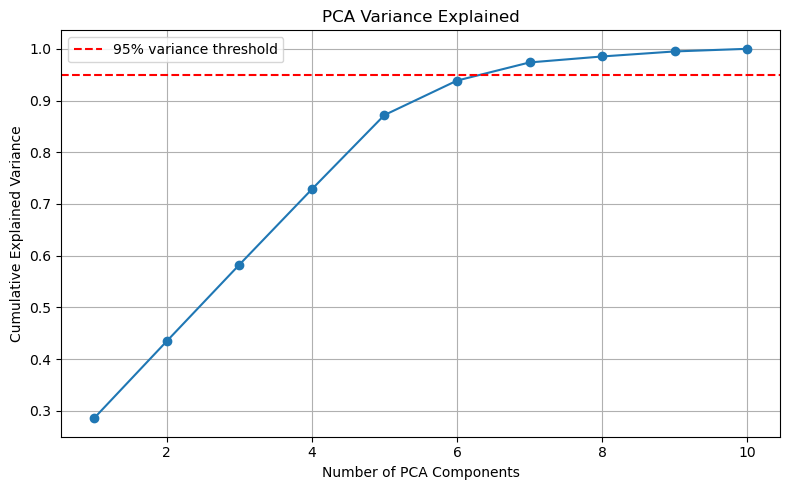

In [11]:
# === 2. Plot cumulative explained variance ===
pca_full = PCA()
pca_full.fit(X_processed)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% variance threshold')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

- The curve shows that the first few components capture most of the variance — e.g., around **95% of the variance is captured by fewer than all features**, indicating significant redundancy in the original feature space.
- This helps determine how many components are needed for effective dimensionality reduction while preserving most information.
- Useful for selecting an optimal number of PCA components (e.g., when to stop).

### Linear Regression MSE vs PCA Dimensions

- For each number of PCA components (from 1 to full dimensionality):
  - Transform the data using PCA.
  - Train a linear regression model.
  - Evaluate the model using MSE on the test set.
- Plot the MSE to see how reducing dimensionality affects performance.

**Goal**: Find a trade-off between performance and dimensionality.


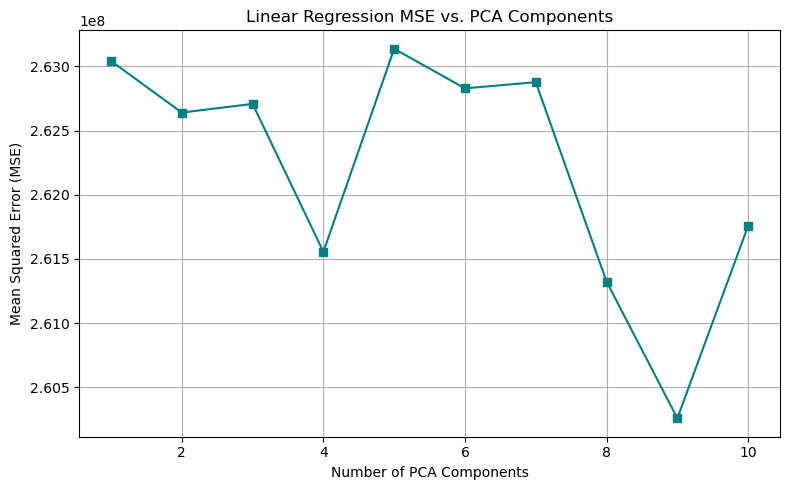

In [12]:
# === 3. Linear Regression MSE across PCA dimensions ===
mse_list = []
component_range = range(1, X_processed.shape[1] + 1)

for n in component_range:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_processed)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=42)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

    # Plot MSE vs. PCA components
plt.figure(figsize=(8, 5))
plt.plot(component_range, mse_list, marker='s', color='teal')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Linear Regression MSE vs. PCA Components')
plt.grid(True)
plt.tight_layout()
plt.show()


- Initially, MSE decreases as more components are added, since the model captures more relevant information.
- After a certain point, adding more components yields **diminishing returns**, meaning the additional features aren't contributing much to predictive performance.
- This validates that PCA can compress the feature space **without sacrificing much accuracy**.

### Single Component PCA Comparison 

- Reduce data to just **1 PCA component**.
- Train and evaluate three models:
  - Linear Regression
  - Support Vector Regression (SVR)
  - K-Nearest Neighbors (KNN)
- Visualize predictions vs. actuals in a scatterplot.

See how well models perform with extreme dimensionality reduction (1 feature).


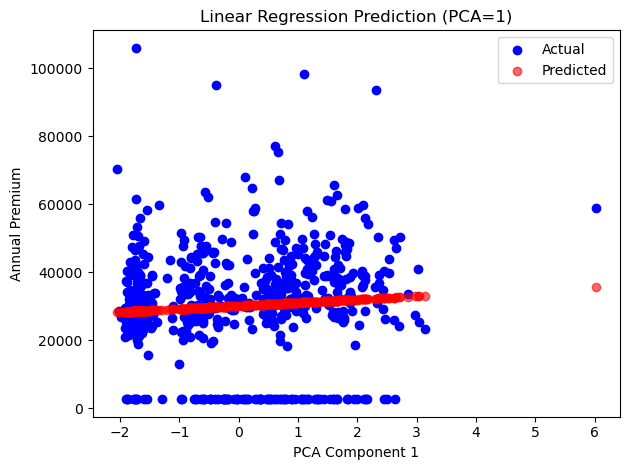

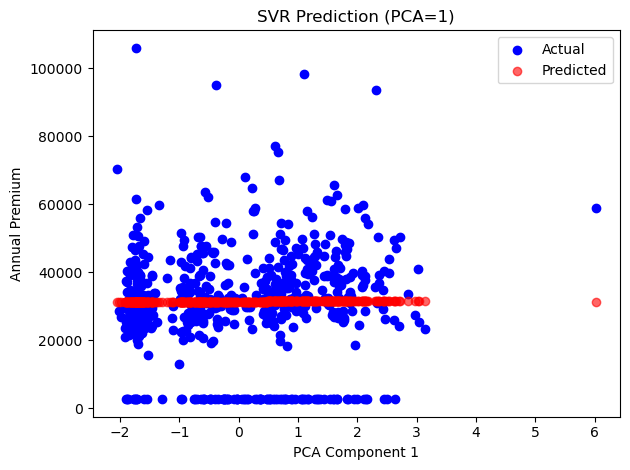

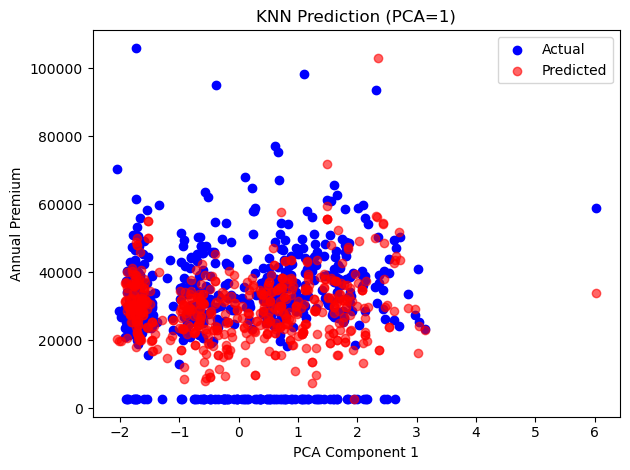

In [13]:
# === 4. PCA = 1 Comparison for 3 Models ===
models = [
    ("Linear Regression", LinearRegression()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor(n_neighbors=4))
]

pca1 = PCA(n_components=1)
X_pca1 = pca1.fit_transform(X_processed)
X_train, X_test, y_train, y_test = train_test_split(X_pca1, y, random_state=42)

mse_pca1 = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_pca1[name] = mse

    # Scatterplot of actual vs predicted for PCA = 1
    plt.figure()
    plt.scatter(X_test, y_test, color='blue', label='Actual')
    plt.scatter(X_test, y_pred, color='red', alpha=0.6, label='Predicted')
    plt.title(f'{name} Prediction (PCA=1)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('Annual Premium')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Linear Regression
- The spread indicates that using only one component results in a **weak linear approximation**, though some general trend is captured.
- The line of best fit deviates from the diagonal, suggesting underfitting and missing detail — expected with only 1 feature.

### SVR 
- The spread of points is slightly more concentrated around the diagonal compared to linear regression, indicating that SVR captures nonlinear patterns even with minimal data.
- However, performance is still **limited by the lack of dimensions**, resulting in prediction errors for more extreme premium values.

### KNN
- The result is **noisy and blocky**, characteristic of KNN with low-dimensional input.
- KNN struggles to separate customers based on similar premiums when all data is collapsed into a single axis — making it the least stable of the three under dimensional collapse.


### Full Model Comparison 

- Run the same MSE analysis across PCA dimensions for **all three models**.
- Store MSEs in a results dictionary.
- Visualize with a single multi-line plot showing each model's performance.

Helps compare model robustness and sensitivity to the number of components.


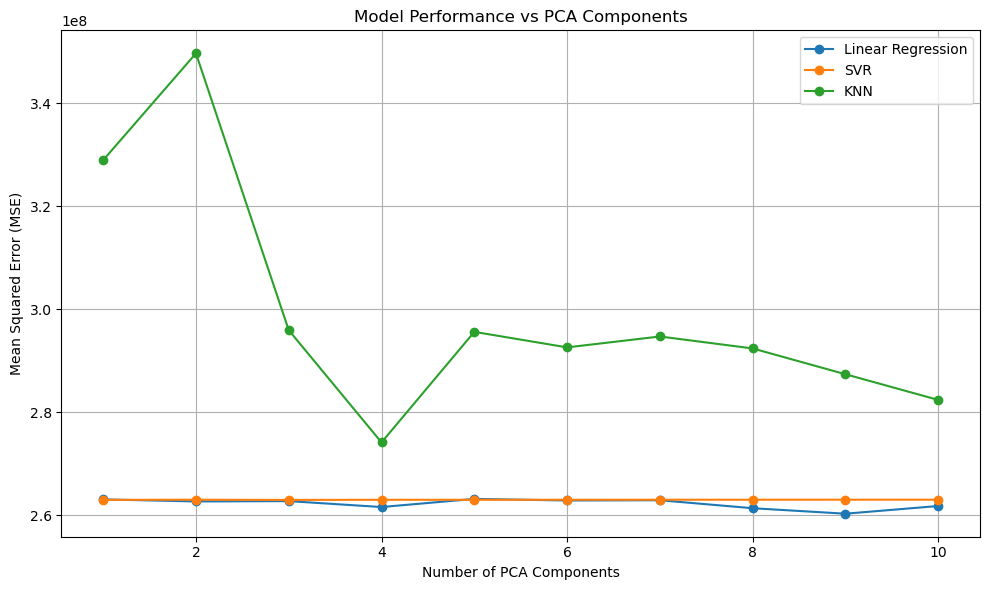

In [14]:
# === 5. Full Model Comparison: MSE vs PCA Components ===
models = [
    ("Linear Regression", LinearRegression()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor(n_neighbors=4))
]

results = {name: [] for name, _ in models}
component_range = range(1, X_processed.shape[1] + 1)

for n in component_range:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_processed)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=42)

    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results[name].append(mse)

# === Final Line Chart: MSE vs PCA Components for All Models ===
plt.figure(figsize=(10, 6))
for name in results:
    plt.plot(component_range, results[name], marker='o', label=name)

plt.title("Model Performance vs PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Linear Regression performs the worst at low dimensions but **improves steadily** with more components.
- SVR starts strong with fewer components, showing **resilience to dimensionality reduction**.
- KNN performs inconsistently across dimensions — it improves after 5+ components but shows instability due to its sensitivity to input geometry.
- Overall, this plot shows that **SVR is most robust** when working with compressed representations, while KNN needs more dimensions to perform reliably.


## Conclusion and Next Steps


In this notebook, we explored **Principal Component Analysis (PCA)** as a dimensionality reduction technique and evaluated how well different regression models (Linear Regression, SVR, KNN) performed when trained on reduced feature sets.

- **PCA effectively compressed the feature space**: The first few principal components captured a large portion of the data’s variance, confirming that many original features were redundant.
- **Model performance varied across dimensions**:
  - **Linear Regression** improved steadily as more components were added.
  - **SVR** showed strong performance even with 1–2 components, making it the most robust to dimensionality reduction.
  - **KNN** struggled at low dimensions but improved once sufficient geometric structure was restored (5+ components).
- A **single PCA component is not sufficient** for accurate premium prediction — though it still preserved a rough trend, high errors persisted.


### Limitations

- PCA assumes **linear relationships** and may not capture complex nonlinear structure in the data.
- By focusing only on explained variance, PCA may **ignore important predictive features** that don’t contribute much variance.
- Evaluation was limited to **regression accuracy (MSE)**; interpretability of components and their feature makeup was not deeply analyzed.


### 💼 Practical Implications

In insurance analytics and other business applications, PCA can help:
- Reduce model complexity and training time
- Visualize customer profiles in 2D for segmentation
- Highlight latent structure in high-dimensional policy data
However, care must be taken to interpret the reduced dimensions meaningfully and validate model performance to avoid oversimplification.

